# Trying out Bayesian Flow Networks

Trying out the discrete case.

In [1]:
import bfn.train_and_sample as tas
import bfn.example_data as example_data
import bfn.training as training
import bfn.models as models

In [2]:
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import jax
import optax
from tqdm import tqdm
from functools import partial
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

### Trying Training

In [3]:
data = example_data.StringDataset("elisroberts", 100, 0.15)

In [4]:
# Initialize model
model = models.DiscreteOutputDistribution(data.num_cats, data.d)
thetas_prior = jnp.ones((data.num_cats, data.d)) / data.num_cats

variables = model.init(jr.PRNGKey(0), thetas_prior, 1.0)
params = variables["params"]

In [5]:
optim = optax.adam(1e-3)
opt_state = optim.init(params)

In [6]:
batch_size = 32
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=jnp.stack)

In [7]:
NUM_EPOCHS = 1000
losses = []
key = jr.PRNGKey(0)
beta_1 = 4.0
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for x_batch in dataloader:
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step_batch(model, x_batch, optim, opt_state, params, beta_1, key=subkey)
        epoch_loss += loss
    losses.append(epoch_loss)
    pbar.set_description(f"Loss: {epoch_loss:.1f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 22.0: 100%|██████████| 1000/1000 [00:37<00:00, 26.82it/s]


In [12]:
sample_key = jr.PRNGKey(19)
output, thetas_output = tas.sample(params, model, beta_1, 1000, key=sample_key)
sampled_name = example_data.detokenize_string(output)
sampled_name

'elpsroherts'

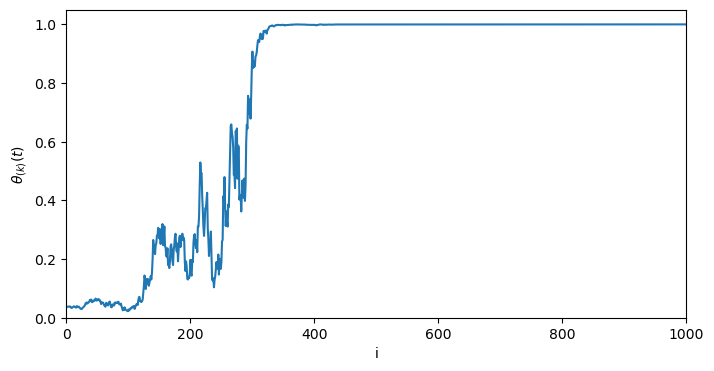

In [23]:
me = "elisroberts"
pos = 3
letter = example_data.tokenize_string(me[pos])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(thetas_output[:, letter, pos])

_ = ax.set_xlabel("i")
_ = ax.set_ylabel(r"$\theta_{(k)}(t)$")
_ = ax.set_xlim(0, thetas_output.shape[0])
_ = ax.set_ylim(0, 1.05)

In [10]:
def visualize_array(array, max_font_size=20):
    """
    Visualize a numpy array of shape (timestep, alphabet, position) using matplotlib.
    This version removes axis tick labels and scales font sizes.
    
    Parameters:
    - array (np.ndarray): Numpy array to visualize.
    - max_font_size (int): Maximum allowable font size for the text.
    """
    
    timesteps, num_alphabets, string_length = array.shape
    
    # Define the alphabets including the blank
    alphabets = [' '] + [chr(i) for i in range(65, 65 + num_alphabets - 1)]
    
    # Create a subplot for each timestep
    fig, axes = plt.subplots(timesteps, 1, figsize=(12, 20))
    
    for t, ax in enumerate(axes):
        for pos in range(string_length):
            for alpha in range(num_alphabets):
                # Determine the position for the text
                x = pos
                y = alpha
                
                # Determine the size of the text based on the probability value in the array
                # Scale it so that it does not exceed max_font_size
                text_size = min(array[t, alpha, pos] * 100, max_font_size)
                
                # Place the text on the plot
                ax.text(x, y, alphabets[alpha], fontsize=text_size, ha='center', va='center')
        
        # Remove axis labels and ticks
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f'Timestep {t + 1}')
        
        # Hide grid lines
        ax.grid(False)
    
    plt.tight_layout()
    plt.show()

In [11]:
thetas_smaller = thetas_output[::10,:,:]